In [52]:
# This generates configuration values with Capytaine.

#!pip install capytaine #uncomment if first time running

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
import copy
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force


In [81]:
def save_potential_array(title, arr):
    file_path = title + "-real" + ".csv"
    np.savetxt(file_path, np.real(arr), delimiter=",", fmt="%.6e")
    file_path = title + "-imag" + ".csv"
    np.savetxt(file_path, np.imag(arr), delimiter=",", fmt="%.6e")

In [58]:
def body_from_profile(x,y,z,nphi):
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(x,y,z)])    # /sqrt(2) to account for the scaling
    body = cpt.FloatingBody(cpt.AxialSymmetricMesh.from_profile(xyz, nphi=nphi))
    return body

def make_surface(ztop, zbot, rin, rout, fdensity, tdensity):
    zarr = np.linspace(- zbot, -ztop, fdensity)
    rarr = np.linspace( rin, rout, fdensity)
    return body_from_profile(rarr, rarr, zarr, tdensity)

def make_body(d, a, zdensities, rdensities, tdensities):
    # top_surface = make_surface(0, 0, 0, a[-1], fdensity, cdensity)
    
    bot_surface = make_surface(d[0], d[0], 0, a[0], rdensities[0], tdensities[0])

    outer_surface = make_surface(0 , d[-1], a[-1], a[-1], zdensities[-1], tdensities[-1])

    bod = bot_surface + outer_surface # + top_surface

    for i in range(1, len(a)):
      # make sides
        side = make_surface( d[i] , d[i-1], a[i-1], a[i-1], zdensities[i-1], tdensities[i-1])
      # make bottoms
        bot = make_surface( d[i] , d[i], a[i-1], a[i], rdensities[i], tdensities[i])
        bod = bod + side + bot

    return bod

In [59]:
solver = cpt.BEMSolver()
def rb_solve(d, a, zdensities, rdensities, tdensities, rho):
    body = make_body(d, a, zdensities, rdensities, tdensities)
    body.add_translation_dof(name='Heave')
    body = body.immersed_part()
    body.show_matplotlib()
    
    rad_problem = cpt.RadiationProblem(body=body, wavenumber = w, water_depth=h, rho = rho)
    results = solver.solve(rad_problem, keep_details = True)
    return results
    

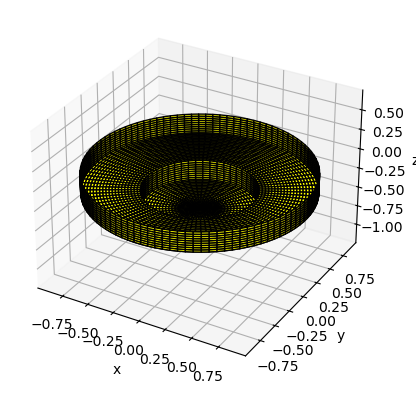

{'Heave': 1586.9919662153031}
{'Heave': 3192.5487228870293}


In [61]:
#original  - compound cylinder
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
w = 1
rho = 1023 # density of our special material
zdensities = [10, 10]
rdensities = [20, 20]
tdensities = [50, 100]
config = "config0"

result = rb_solve(d, a, zdensities, rdensities, tdensities, rho)
print(result.added_mass)
print(result.radiation_damping)

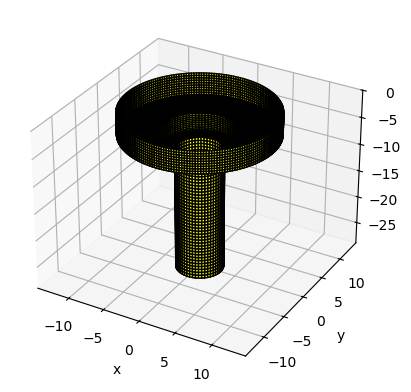

TypeError: 'RadiationResult' object is not subscriptable

In [70]:
#really tall  - compound cylinder
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
w = 1
rho = 1023 # density of our special material
zdensities = [40, 10, 10]
rdensities = [15, 10, 25]
tdensities = [50, 80, 200]
config = "config2"

result = rb_solve(d, a, zdensities, rdensities, tdensities, rho)
print(result.added_mass)
print(result.radiation_damping)

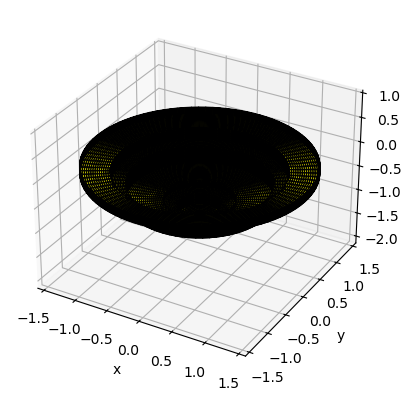

{'Heave': 4684.697964071632}
{'Heave': 11442.873388156791}


In [83]:
#staircase  - compound cylinder
h = 1.5
d = [1.1, 0.85, 0.75, 0.4, 0.15]
a = [0.3, 0.5, 1, 1.2, 1.6]
w = 1
rho = 1023 # density of our special material
zdensities = [20, 10, 30, 20, 15]
rdensities = [10, 10, 20, 10, 15]
tdensities = [40, 50, 70, 80, 100]
config = "config1"

result = rb_solve(d, a, zdensities, rdensities, tdensities, rho)
print(result.added_mass)
print(result.radiation_damping)

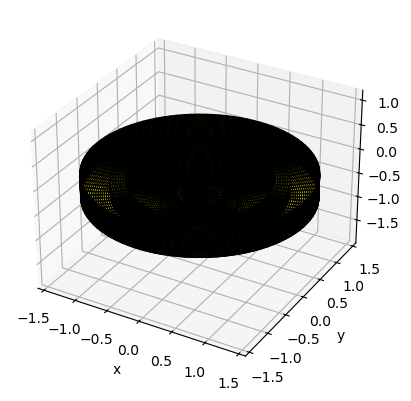

{'Heave': 5863.802922240765}
{'Heave': 6745.273820418929}


In [77]:
#indents  - compound cylinder
h = 1.9
d = [0.5, 0.7, 0.8, 0.2, 0.5]
a = [0.3, 0.5, 1, 1.2, 1.6]
w = 1
rho = 1023 # density of our special material
zdensities = [15, 10, 30, 15, 25]
rdensities = [10, 10, 20, 10, 15]
tdensities = [40, 50, 70, 80, 100]
config = "config3"

result = rb_solve(d, a, zdensities, rdensities, tdensities, rho)
print(result.added_mass)
print(result.radiation_damping)

In [84]:
# Get potentials
# Define the ranges for R and Z
R_range = np.linspace(0.0, 2*a[-1], num=50)
theta_range = np.linspace(-np.pi, np.pi, num=4)
Z_range = np.linspace(0, -h, num=50) #h

# Create mesh grids for R, theta, and Z
R, theta, Z = np.meshgrid(R_range, theta_range, Z_range, indexing='ij')

# Convert cylindrical coordinates to Cartesian coordinates for capytaine
X = R * np.cos(theta)
Y = R * np.sin(theta)
Z = Z
# Create an array of shape (N, 3)
points = np.zeros((R.size, 3))

# Assign the values of R, Z, and y to the array
points[:, 0] = X.ravel()
points[:, 1] = Y.ravel()
points[:, 2] = Z.ravel()
#need cartesian here
phi_inc = solver.compute_potential(points,result) #rad problem

regions = []
regions.append((R <= a[0]) & (Z > -d[0]))
for i in range(1, len(a)):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z > -d[i]))
regions.append(R > a[-1])

# Apply masks to create a blank plot in specified regions
phi_inc = phi_inc.reshape((50,4,50))

for i in range(len(a)):
  phi_inc[regions[i]] = np.nan



In [85]:
vel_inc = solver.compute_velocity(points,result)
velx_inc = vel_inc[:,0].reshape((50,4,50))
vely_inc = vel_inc[:,1].reshape((50,4,50))
velz_inc = vel_inc[:,2].reshape((50,4,50))
for i in range(len(a)):
  velx_inc[regions[i]] = np.nan
  vely_inc[regions[i]] = np.nan
  velz_inc[regions[i]] = np.nan

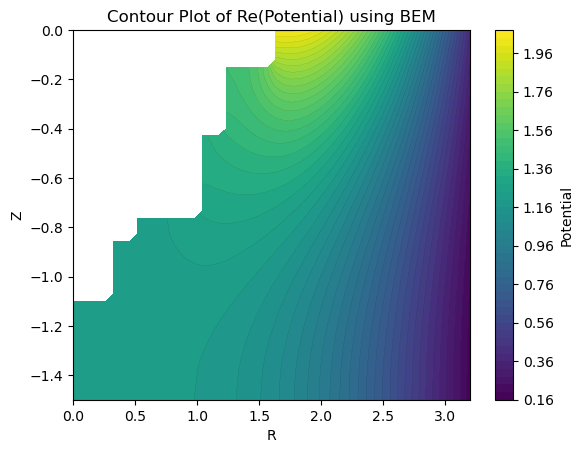

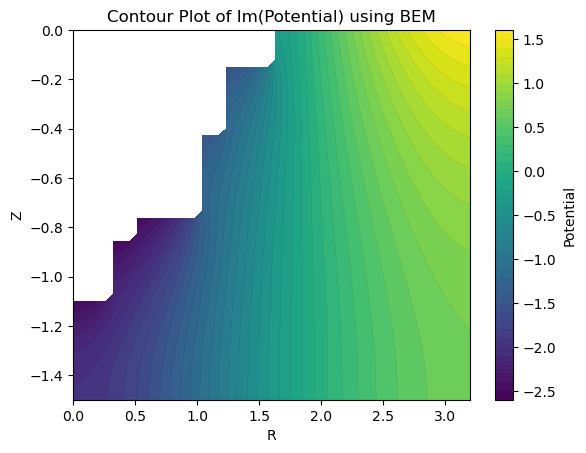

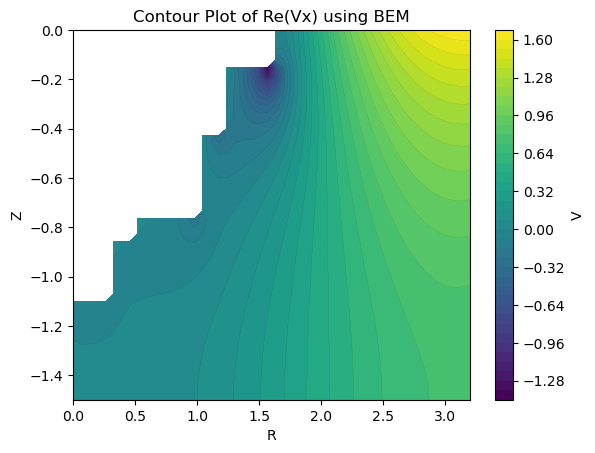

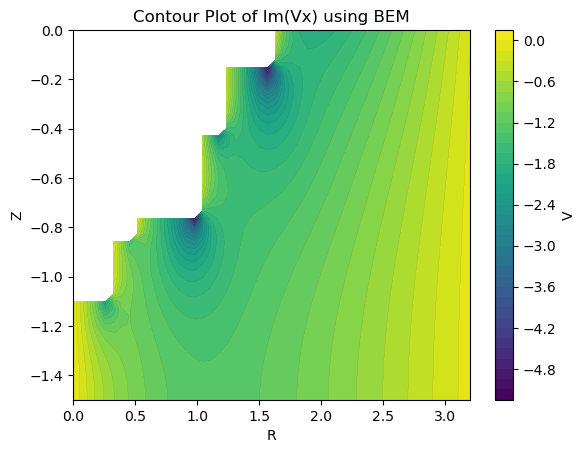

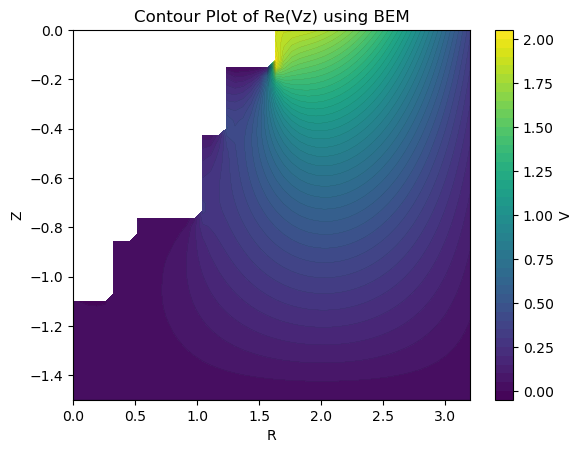

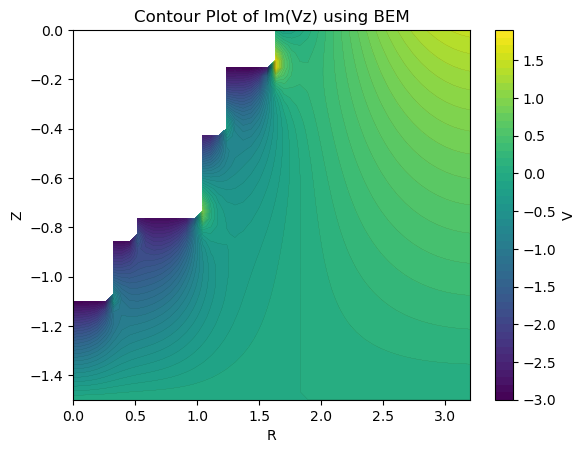

In [86]:
plt.contourf(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Re(Potential) using BEM')

plt.show()

imag_phi_inc = np.imag(phi_inc[:, 0, :])

nan_mask = np.isnan(np.real(phi_inc[:, 0, :]))

np.imag(phi_inc[:, 0, :])[nan_mask] = np.nan

plt.contourf(R[:, 0, :], Z[:, 0, :], imag_phi_inc, cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], imag_phi_inc, colors='black', linestyles='solid', linewidths=0.05,levels=50)


# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Im(Potential) using BEM')

plt.show()

def plot_vel(data, title):
  plt.contourf(R[:, 0, :], Z[:, 0, :], data[:, 0, :], cmap='viridis', levels = 50)
  plt.colorbar(label='V')
  plt.contour(R[:, 0, :], Z[:, 0, :], data[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

  # Add labels and title
  plt.xlabel('R')
  plt.ylabel('Z')
  plt.title(title)

  plt.show()

nan_mask = np.isnan(np.real(velx_inc))

velx_imag = np.imag(velx_inc)
velz_imag = np.imag(velz_inc)

velx_imag[nan_mask] = np.nan
velz_imag[nan_mask] = np.nan

plot_vel(velx_inc, "Contour Plot of Re(Vx) using BEM")
plot_vel(velx_imag, "Contour Plot of Im(Vx) using BEM")
plot_vel(velz_inc, "Contour Plot of Re(Vz) using BEM")
plot_vel(velz_imag, "Contour Plot of Im(Vz) using BEM")


In [87]:
save_potential_array(config, phi_inc[:, 0, :])

In [67]:
print(result.added_mass)
print(result.radiation_damping)
print((result.added_mass)["Heave"]/(result.radiation_damping)["Heave"])

{'Heave': 1586.9919662153031}
{'Heave': 3192.5487228870293}
0.4970924812637417


In [ ]:
# Code blocks below are draft code, not to run but may contain useful content for future reference.

In [2]:
solver = cpt.BEMSolver()
def body_from_profile(x,y,z,nphi):
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(x,y,z)])    # /sqrt(2) to account for the scaling
    body = cpt.FloatingBody(cpt.AxialSymmetricMesh.from_profile(xyz, nphi=nphi))
    return body

def make_shell(top, bottom, inner, outer, zdensity, rdensity, tdensity, heaving):
    outer_surface = make_surface(top, bottom, outer, outer, zdensity, tdensity)
    bottom_surface = make_surface(bottom, bottom, inner, outer, rdensity, tdensity)
    bod = outer_surface + bottom_surface
    if inner > 0:
        inner_surface = make_surface(top, bottom, inner, inner, zdensity, tdensity)
        bod = bod + inner_surface
    if top > 0:
        top_surface = make_surface(top, top, inner, outer, rdensity, tdensity)
        bod = bod + top_surface
    if heaving:
        bod.add_translation_dof(name='Heave')
    return bod


def make_bodies(attribute_lst):
    bod_lst = []
    for att in attribute_lst:
        bod_lst.append(make_shell(att["top"], att["bottom"], att["inner"], att["outer"], att["zdensity"], att["rdensity"], att["tdensity"], att["heaving"]))
    return bod_lst

# getting an attribute list from the current multi-meem input setup
def gen_to_att_lst(d, a, zdensities, rdensities, tdensities, heaving, epsilon):
    ct = len(d)
    tops = [0] * ct
    bottoms = d
    inners = [0 - epsilon] + a[:-1]
    outers = a
    att_lst = []
    key_lst = ["top", "bottom", "inner", "outer", "zdensity", "rdensity", "tdensity", "heaving"]
    for i in range(ct):
        vals = [tops[i], bottoms[i], inners[i] + epsilon, outers[i] - epsilon, zdensities[i], rdensities[i], tdensities[i], heaving[i]]
        att = {}
        for j in range(len(key_lst)):
            att[key_lst[j]] = vals[j]
        att_lst.append(att)

    return att_lst
    
def plt_bodies(bod_lst):
    prime = copy.deepcopy(bod_lst) # don't disturb the dofs of the originals
    newbod = prime[0]
    for body in prime[1:]:
        newbod = newbod + body
    newbod.show_matplotlib()


def rb_solve(body_lst, m0, h, rho):
    prime = copy.deepcopy(bod_lst)
    newbod = prime[0]
    for body in prime[1:]:
        newbod = newbod + body
    rad_problem = cpt.RadiationProblem(body = newbod, wavenumber = m0, water_depth = h, rho = rho)
    results = solver.solve(rad_problem, keep_details = True)
    return results, body.mesh.nb_faces

def complete_solve(d, a, zdensities, rdensities, tdensities, heaving, epsilon, m0, h, rho):
    att_lst = gen_to_att_lst(d, a, zdensities, rdensities, tdensities, heaving, epsilon)
    bod_lst = make_bodies(att_lst)
    plt_bodies(bod_lst)
    result = rb_solve(bod_lst, m0, h, rho)
    print(result.added_mass)
    print(result.radiation_damping)
    return result



In [ ]:
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
m0 = 1
rho = 1023
heaving = [1, 1]
zdensities = [10, 5]
rdensities = [5, 5]
tdensities = [20, 40]

att_lst = gen_to_att_lst(d, a, zdensities, rdensities, tdensities, heaving, 0.001)
bod_lst = make_bodies(att_lst)
plt_bodies(bod_lst)

body = bod_lst[0] + bod_lst[1]

rad_problem = cpt.RadiationProblem(body=body, wavenumber = m0, water_depth=h, rho = rho)
results = solver.solve(rad_problem, keep_details = True)

#results = rb_solve(bod_lst, m0, h, rho)
print(results.added_mass)
print(results.radiation_damping)


In [ ]:
resolution = 0.4

solver = cpt.BEMSolver()
def bemCompoundCylinder(h,a,d,resolution):
  bodies = []
  for i in range(len(a)-1):
    body = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a[i],center=(0,0,-d[i+1] - 0.001),length = d[i] - d[i+1],faces_max_radius=resolution*a[-1])
    bodies.append(body)
  body = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a[-1],center=(0,0,0),length = d[-1],faces_max_radius=resolution*a[-1])
  bodies.append(body)

  #body2 = cpt.meshes.predefined.mesh_vertical_cylinder(radius= a2,center=(0,0,0),length = d2,faces_max_radius=resolution*a2)
  #body1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a1,center=(0,0,0),length = d1-d2,faces_max_radius=resolution*a2)
  #body1 = body1.translated([0,0,-d2-0.001])

  body = bodies[0]
  for i in range(len(a)-1):
    body = body + bodies[i+1]
  body = cpt.FloatingBody(body)
  body.add_translation_dof(name='Heave')
  body = body.immersed_part()
  #body.show_matplotlib()
  faces_centers = body.mesh.faces_centers

  rad_problem = cpt.RadiationProblem(body=body,
                                        wavenumber = w, water_depth=h)
  results = solver.solve(rad_problem, keep_details = True)
  return results , body.mesh.nb_faces

result = bemCompoundCylinder(h, a, d,resolution)
